In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model
from sklearn.model_selection import StratifiedKFold

import model3 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss, dice_loss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
# Settings
# ========

# Target k in KFold
CV = 0

# Skip pretraining
skip_pretraining = False

In [5]:
train_df, val_df = get_dfs_fold(k=CV)

train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    as_aux_label='coverage_class',
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
print('Loaded dataset and created loader')

Use augmentations
Loaded dataset and created loader


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34AuxSimple(n_classes=1, n_aux_classes=8)
model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion_phase1(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = F.binary_cross_entropy_with_logits(logit.view(-1), target_pixel.view(-1), size_average=True)
    segmentation_dice_loss = dice_loss(logit, target_pixel)
    
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return 0.5 * segmentation_loss + 0.5 * segmentation_dice_loss + 0.05 * classification_loss

In [8]:
def train_phase1(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 10
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase1(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_aux_simple_aug_kfold_cv{CV}_phase1')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [9]:
if not skip_pretraining:
    model = train_phase1(model, 50, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-16 21:14:05.952752] Train Epoch: 0 [0/3198 (0%)]	Average loss: 0.021658
[2018-10-16 21:14:30.831411] Train Epoch: 0 [1800/3198 (56%)]	Average loss: 0.015806
[2018-10-16 21:14:30.831411] Train Epoch: 0	IoU: 0.521322
Saved model at 0 (IoU: 0.5213216957605985)
[2018-10-16 21:14:58.797343] Train Epoch: 1 [0/3198 (0%)]	Average loss: 0.011285
[2018-10-16 21:15:23.799596] Train Epoch: 1 [1800/3198 (56%)]	Average loss: 0.010483
[2018-10-16 21:15:23.799596] Train Epoch: 1	IoU: 0.572444
Saved model at 1 (IoU: 0.5724438902743142)
[2018-10-16 21:15:51.383549] Train Epoch: 2 [0/3198 (0%)]	Average loss: 0.009530
[2018-10-16 21:16:16.471061] Train Epoch: 2 [1800/3198 (56%)]	Average loss: 0.008962
[2018-10-16 21:16:16.471061] Train Epoch: 2	IoU: 0.604738
Saved model at 2 (IoU: 0.6047381546134664)
[2018-10-16 21:16:44.080502] Train Epoch: 3 [0/3198 (0%)]	Average loss: 0.009695
[2018-10-16 21:17:09.132252] Train Epoch: 3 [1800/3198 (56%)]	Average loss: 0.008051
[2018-10-16 21:17:09.132252] Trai

In [10]:
def criterion_phase2(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze())
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return segmentation_loss + 0.05 * classification_loss

In [11]:
def train_phase2(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 10
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase2(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_aux_simple_aug_kfold_cv{CV}_phase2')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [12]:
model = train_phase2(model, 60, train_loader, val_loader)

[2018-10-16 21:40:20.243547] Train Epoch: 0 [0/3198 (0%)]	Average loss: 0.052451
[2018-10-16 21:40:49.642215] Train Epoch: 0 [1800/3198 (56%)]	Average loss: 0.036216
[2018-10-16 21:40:49.642215] Train Epoch: 0	IoU: 0.734539
Saved model at 0 (IoU: 0.7345386533665835)
[2018-10-16 21:41:20.961703] Train Epoch: 1 [0/3198 (0%)]	Average loss: 0.028757
[2018-10-16 21:41:50.261534] Train Epoch: 1 [1800/3198 (56%)]	Average loss: 0.033987
[2018-10-16 21:41:50.261534] Train Epoch: 1	IoU: 0.677805
[2018-10-16 21:42:20.852054] Train Epoch: 2 [0/3198 (0%)]	Average loss: 0.043360
[2018-10-16 21:42:50.180222] Train Epoch: 2 [1800/3198 (56%)]	Average loss: 0.028716
[2018-10-16 21:42:50.180222] Train Epoch: 2	IoU: 0.751746
Saved model at 2 (IoU: 0.7517456359102244)
[2018-10-16 21:43:21.115461] Train Epoch: 3 [0/3198 (0%)]	Average loss: 0.027540
[2018-10-16 21:43:50.461718] Train Epoch: 3 [1800/3198 (56%)]	Average loss: 0.027161
[2018-10-16 21:43:50.461718] Train Epoch: 3	IoU: 0.770075
Saved model at 3 (

[2018-10-16 22:15:25.103290] Train Epoch: 34 [1800/3198 (56%)]	Average loss: 0.010707
[2018-10-16 22:15:25.103290] Train Epoch: 34	IoU: 0.810474
Saved model at 34 (IoU: 0.8104738154613467)
[2018-10-16 22:15:55.994070] Train Epoch: 35 [0/3198 (0%)]	Average loss: 0.008545
[2018-10-16 22:16:25.276495] Train Epoch: 35 [1800/3198 (56%)]	Average loss: 0.011649
[2018-10-16 22:16:25.276495] Train Epoch: 35	IoU: 0.798130
[2018-10-16 22:16:55.914957] Train Epoch: 36 [0/3198 (0%)]	Average loss: 0.016924
[2018-10-16 22:17:25.211662] Train Epoch: 36 [1800/3198 (56%)]	Average loss: 0.011371
[2018-10-16 22:17:25.211662] Train Epoch: 36	IoU: 0.811970
Saved model at 36 (IoU: 0.8119700748129677)
[2018-10-16 22:17:56.119287] Train Epoch: 37 [0/3198 (0%)]	Average loss: 0.009780
[2018-10-16 22:18:25.415113] Train Epoch: 37 [1800/3198 (56%)]	Average loss: 0.009798
[2018-10-16 22:18:25.415113] Train Epoch: 37	IoU: 0.802369
[2018-10-16 22:18:56.055053] Train Epoch: 38 [0/3198 (0%)]	Average loss: 0.006392
[201

In [13]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

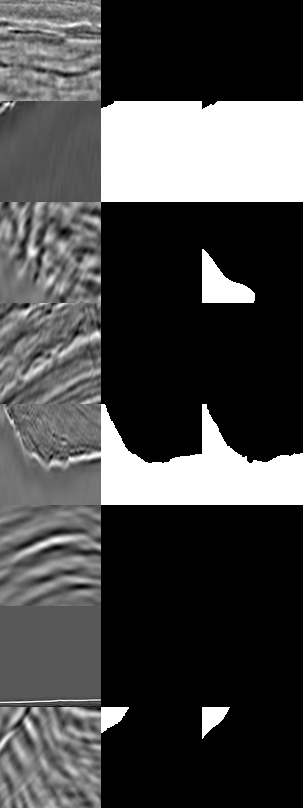

In [14]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=True, threshold=0.5)
show_prediction(im, pred, t)

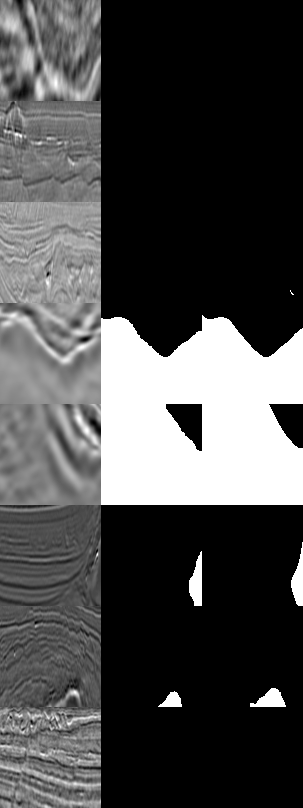

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

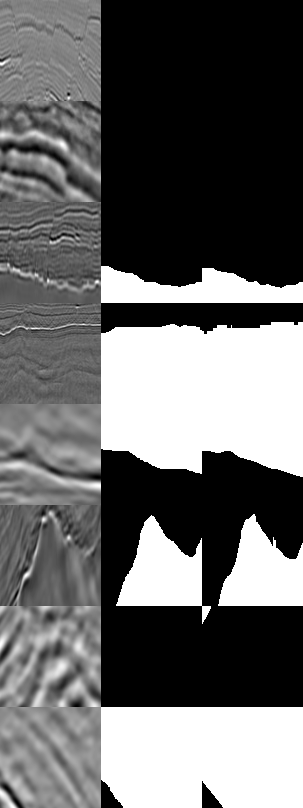

In [16]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

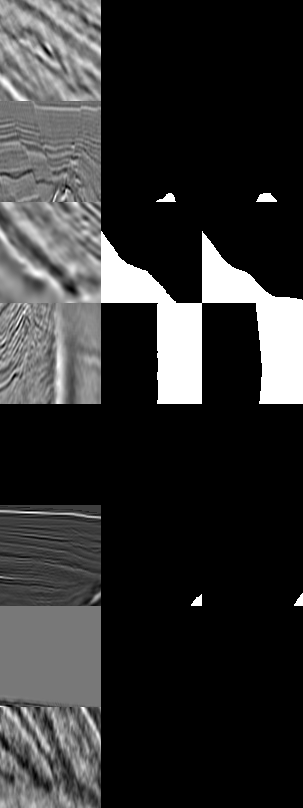

In [17]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)